## Run multiple frameworks with Appose

Call multiple deep learning frameworks (cellpose cyto3, cellposesam, microsam, and mobilesam) in the same notebook


### Import Segmenters and execute_appose from napari_ai_lab

**What are Segmenters?** 
Segmenters are classes that wrap deep learning models with useful logic:
- Check if dependencies are available locally ([see here](https://github.com/True-North-Intelligent-Algorithms/napari-ai-lab/blob/main/src/napari_ai_lab/Segmenters/GlobalSegmenters/CellposeSegmenter.py#L15))
- If not available locally, provide execution strings suitable for Appose ([see here](https://github.com/True-North-Intelligent-Algorithms/napari-ai-lab/blob/main/src/napari_ai_lab/Segmenters/GlobalSegmenters/CellposeSegmenter.py#L184))

**What is execute_appose?**
A utility function ([see here](https://github.com/True-North-Intelligent-Algorithms/napari-ai-lab/blob/main/src/napari_ai_lab/Segmenters/execute_appose.py)) that takes a segmenter and wraps all the Appose logic needed to create environments and call execution strings.

**Note:** This is very early experimental work. Myself and other people will be iterating on such code and better designs will be coming in the future!

In [1]:
import os
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import torch

# Project helpers and segmenters
from tnia.plotting.plt_helper import mask_overlay
from napari_ai_lab.Segmenters.GlobalSegmenters.CellposeSegmenter import CellposeSegmenter
from napari_ai_lab.Segmenters.execute_appose import execute_appose

# MicroSAM automatic segmentation
from micro_sam.automatic_segmentation import get_predictor_and_segmenter, automatic_instance_segmentation

/home/bnorthan/code/i2k/tnia/reproducible-dl-seg-article/pixi/microsam_cellposesam/.pixi/envs/default/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load test images

Load the same test images we deid in previous notebooks

Available images:
[0] Snap_060 (2).jpg
[1] Snap_055.jpg
[2] TestHidden_005.bmp
[3] Snap_061 (2).jpg
[4] BloodImage_00134_jpg.rf.0d9da503b62e0034a2819a39cce7e7d9.jpg
[5] BloodImage_00154_jpg.rf.e5b45569e9cbede1ed36f82f14566c29.jpg
[6] BloodImage_00160_jpg.rf.894e8c8c7179ec9958a4d6c7b6b45616.jpg
Selected index: 6
Using image: ../../../reproducible-dl-seg-article/data/addhopin blood cells/subset/BloodImage_00160_jpg.rf.894e8c8c7179ec9958a4d6c7b6b45616.jpg
Image tag: BloodImage_00160_jpg.rf.894e8c8c7179ec9958a4d6c7b6b45616
Label: <None>
Loaded image shape: (416, 416, 3), dtype: uint8


(np.float64(-0.5), np.float64(415.5), np.float64(415.5), np.float64(-0.5))

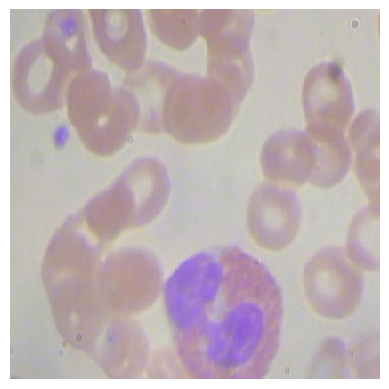

In [2]:
# Choose sample image by number (same pattern as 11/14)
# Uses a small list and a single selection_index.

# Available image options (indexed)
image_options = [
    r"../../../reproducible-dl-seg-article/data/Blood cell Cancer [ALL]/benign/Snap_060 (2).jpg",
    r"../../../reproducible-dl-seg-article/data/Blood cell Cancer [ALL]/benign/Snap_055.jpg",
    r"../../../reproducible-dl-seg-article/data/SOTA/TestHidden_005.bmp",
    r"../../../reproducible-dl-seg-article/data/Blood cell Cancer [ALL]/benign/Snap_061 (2).jpg",
    r"../../../reproducible-dl-seg-article/data/addhopin blood cells/test/images/BloodImage_00134_jpg.rf.0d9da503b62e0034a2819a39cce7e7d9.jpg",
    r"../../../reproducible-dl-seg-article/data/addhopin blood cells/test/images/BloodImage_00154_jpg.rf.e5b45569e9cbede1ed36f82f14566c29.jpg",
    r"../../../reproducible-dl-seg-article/data/addhopin blood cells/subset/BloodImage_00160_jpg.rf.894e8c8c7179ec9958a4d6c7b6b45616.jpg"
]

# Matching label options (indexed one-to-one with image_options)
label_options = [
    None,
    None,
    r"../../../reproducible-dl-seg-article/data/SOTA/TestHidden_005.tif",
    None,
    None,
    None,
    None
]

# Index guide (set selection_index below):
# [0] Snap_060 (2).jpg
# [1] Snap_055.jpg
# [2] TestHidden_005.bmp
# [3] Snap_061 (2).jpg
# [4] BloodImage_00134_....jpg
# [5] BloodImage_00154_....jpg
# [6] BloodImage_00160_....jpg

# Choose by number: change this to desired index
selection_index = 6

print("Available images:")
for i, p in enumerate(image_options):
    print(f"[{i}] {os.path.basename(p)}")
print(f"Selected index: {selection_index}")

image_path = image_options[selection_index]
label_path = label_options[selection_index]  # optional ground-truth path (None if not available)

image_name = os.path.splitext(os.path.basename(image_path))[0]
print("Using image:", image_path)
print("Image tag:", image_name)
print("Label:", label_path if label_path is not None else "<None>")

img = io.imread(image_path)

# Ensure 3 channels if grayscale
if len(img.shape) == 2:
    img = np.expand_dims(img, axis=2)
    img = np.repeat(img, 3, axis=2)

# If you have a smaller GPU try cropping image with ROI
# roi = np.s_[100:1100, 100:1100, ...]
roi = np.s_[:]
img = img[roi]

print(f"Loaded image shape: {img.shape}, dtype: {img.dtype}")
plt.imshow(img); plt.axis('off')

### Check If Cellpose is Available Locally

Let's see if Cellpose is available in our current environment. Spoiler: it probably isn't, which is perfect for demonstrating Appose!

In [14]:
# Simple cellpose configuration
segmenter = CellposeSegmenter(model_type="cyto2", diameter=30)

run_in_local_environment = segmenter.are_dependencies_available()

print(f"🔍 Cellpose local: {'✅ Available' if run_in_local_environment else '❌ Not found'}")
    

🔍 Cellpose local: ✅ Available


### Run Cellpose 3 in Different Environment

Now let's call Cellpose 3 using execute_appose! We point to the microsam_cellpose3 environment.

In [15]:
print(segmenter.get_execution_string(img))


import numpy as np
import cellpose
from cellpose import models

# Parameters from segmenter
model_type = "cyto2"
use_gpu = True
diameter = 30
flow_threshold = 0.4
prob_threshold = 0.0
cellpose_iterations = 200

# Image will be provided as 'image' variable
# image.shape = (416, 416, 3)
# image.dtype = uint8

def cellpose_segment_remote(image):
    """Remote cellpose segmentation function."""

    # Get cellpose version and create appropriate model
    major_number = cellpose.version.split('.')[0]
    print(f"Cellpose version: {cellpose.version} (major number: {major_number})")

    try:
        if major_number == '4':
            model = models.CellposeModel(gpu=use_gpu, model_type=model_type)
        else:
            # For version 3 and all other versions, use the older API
            model = models.Cellpose(gpu=use_gpu, model_type=model_type)

        print(f"Created Cellpose model: {model_type}, GPU: {use_gpu}")

    except Exception as e:
        print(f"Error creating Cellpose m

In [16]:
pixi_path = r"../../../reproducible-dl-seg-article/pixi"

cellpose_env_path = os.path.join(pixi_path, r"microsam_cellpose3/.pixi/envs/default")

result = execute_appose(img, segmenter, cellpose_env_path)

cellpose3_result = result.ndarray().copy()

dict_keys(['mask'])


In [17]:
print(result)

NDArray(dtype='uint16', shape=[416, 416], shm='psm_4e3368f8' (346112))


### Run CellposeSAM in Different Environment

Now let's run cellpose in the ```microsam_cellposesam``` environment.  This one has the newer (version 4) cellpose, that uses SAM, so the reult will be different.  

In [18]:
cellpose_env_path = os.path.join(pixi_path, "microsam_cellposesam/.pixi/envs/default")
#cellpose_env_path = r"C:\\Users\\bnort\\miniconda3\\envs\\microsam_cellpose"

result = execute_appose(img, segmenter, cellpose_env_path)

cellposesam_result= result.ndarray().copy()

model_type argument is not used in v4.0.1+. Ignoring this argument...


dict_keys(['mask'])


### Check Result Types

Quick check to make sure we got numpy arrays back from both runs.

In [19]:
type(cellpose3_result), type(cellposesam_result)

(numpy.ndarray, numpy.ndarray)

### Prepare for Visualization

Load ground truth and import the visualization helper to create overlays.

In [20]:

# Load ground truth for comparison
try:
    print("Loading ground truth labels from:", label_path)
    ground_truth = io.imread(label_path)
except Exception as e:
    print(f"Could not load ground truth labels: {e}")
    ground_truth = np.zeros(img.shape[:2], dtype=np.uint8)
# Visualization helper imported at top

Loading ground truth labels from: None
Could not load ground truth labels: Cannot understand given URI: None.


In [21]:
from micro_sam.automatic_segmentation import get_predictor_and_segmenter, automatic_instance_segmentation
import matplotlib.pyplot as plt
import torch

tile_shape = None #(384, 384)
halo = (64, 64)
model_type = "vit_b_lm"

device = "cuda" if torch.cuda.is_available() else "cpu" # the device/GPU used for training
# Step 1: Get the 'predictor' and 'segmenter' to perform automatic instance segmentation.
predictor, segmenter = get_predictor_and_segmenter(
    model_type=model_type, # choice of the Segment Anything model
    #checkpoint=best_checkpoint,  # overwrite to pass your own finetuned model.
    device=device,  # the device to run the model inference.
    is_tiled = False #(tile_shape is not None),  # whether the model is tiled or not.
)


# Step 2: Get the instance segmentation for the given image.
microsam_result = automatic_instance_segmentation(
    predictor=predictor,  # the predictor for the Segment Anything model.
    segmenter=segmenter,  # the segmenter class responsible for generating predictions.
    input_path=img,
    ndim=2,
    tile_shape=tile_shape,
    halo=halo,
)



Initialize instance segmentation with decoder: 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


### Check Results

Verify the shapes and types of our results.

In [24]:
print(f"Image shape: {img.shape}")
print(f"Cellpose 3 result shape: {cellpose3_result.shape}")
print(f"CellposeSAM result shape: {cellposesam_result.shape}")
print(f"MicroSAM result shape: {microsam_result.shape}")
if ground_truth is not None:
    print(f"Ground truth shape: {ground_truth.shape}")

Image shape: (416, 416, 3)
Cellpose 3 result shape: (416, 416)
CellposeSAM result shape: (416, 416)
MicroSAM result shape: (416, 416)
Ground truth shape: (416, 416)


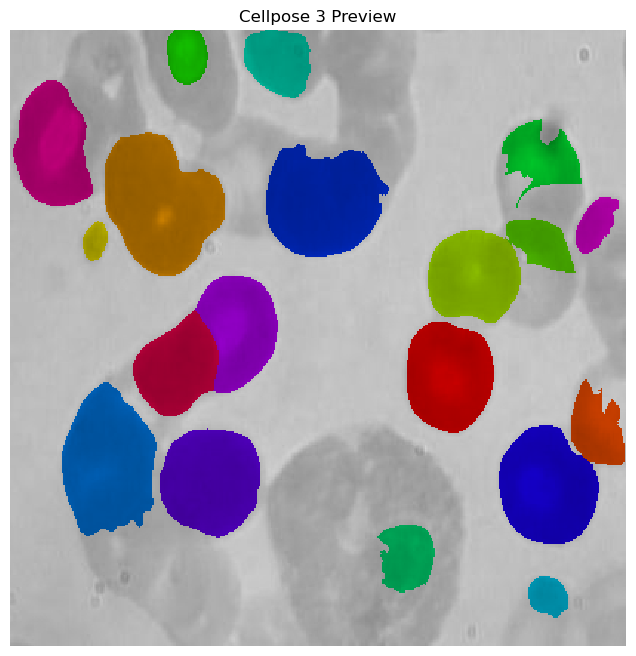

In [25]:
# Quick preview of one result
preview_overlay = mask_overlay(img, cellpose3_result)
plt.figure(figsize=(8, 8))
plt.imshow(preview_overlay)
plt.title('Cellpose 3 Preview')
plt.axis('off')
plt.show()

### Compare All Results

Finally, let's see how all methods performed!

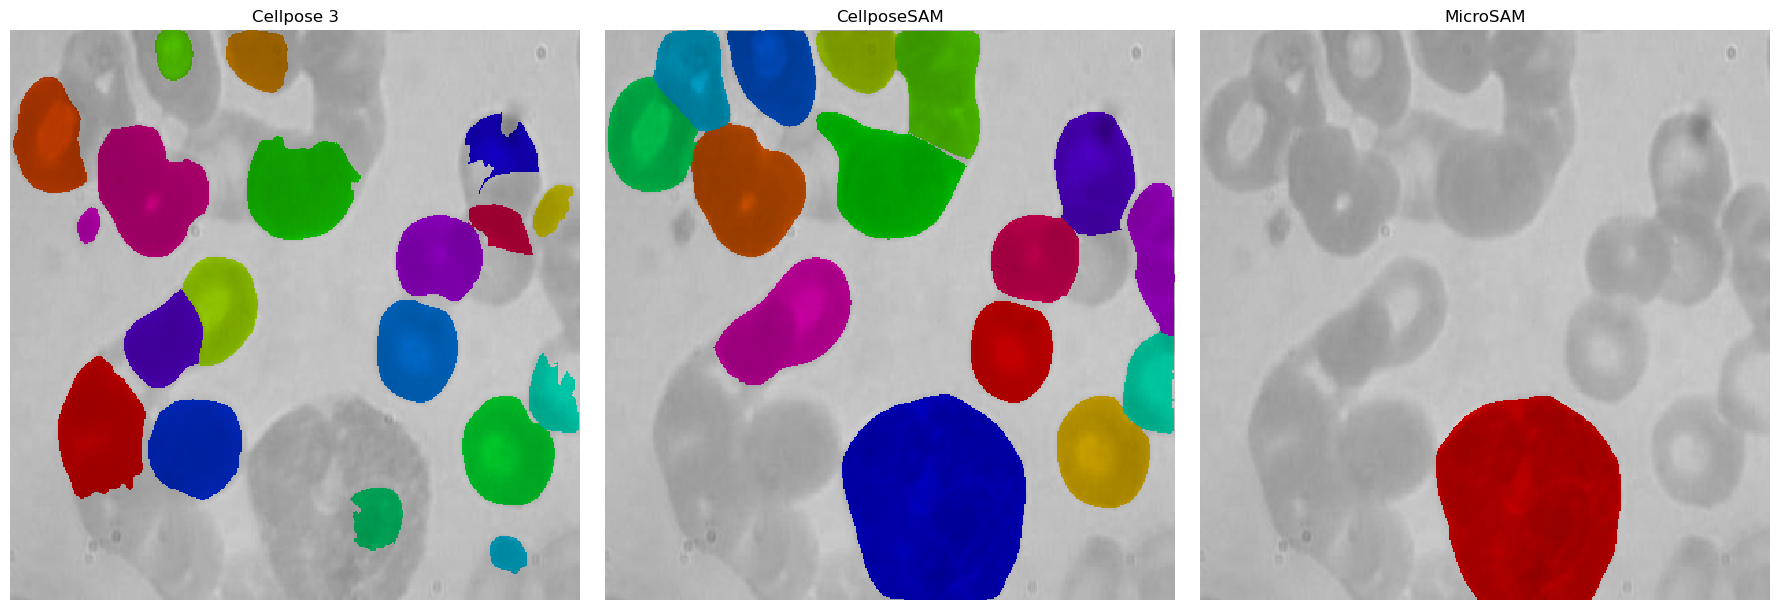

In [26]:


# Create overlays for all results
cellpose3_overlay = mask_overlay(img, cellpose3_result)
cellposesam_overlay = mask_overlay(img, cellposesam_result)
microsam_overlay = mask_overlay(img, microsam_result)

# Check if we have ground truth
has_ground_truth = ground_truth is not None and ground_truth.sum() > 0

# Determine number of panels
num_panels = 4 if has_ground_truth else 3
fig_width = 6 * num_panels

# Create comparison plot
fig, axes = plt.subplots(1, num_panels, figsize=(fig_width, 6))

panel_idx = 0

# Add ground truth if available
if has_ground_truth:
    ground_truth_overlay = mask_overlay(img, ground_truth)
    axes[panel_idx].imshow(ground_truth_overlay)
    axes[panel_idx].set_title('Ground Truth')
    axes[panel_idx].axis('off')
    panel_idx += 1

# Add all methods
axes[panel_idx].imshow(cellpose3_overlay)
axes[panel_idx].set_title('Cellpose 3')
axes[panel_idx].axis('off')

axes[panel_idx + 1].imshow(cellposesam_overlay)
axes[panel_idx + 1].set_title('CellposeSAM')
axes[panel_idx + 1].axis('off')

axes[panel_idx + 2].imshow(microsam_overlay)
axes[panel_idx + 2].set_title('MicroSAM')
axes[panel_idx + 2].axis('off')

plt.tight_layout()
plt.show()